Sampling ...


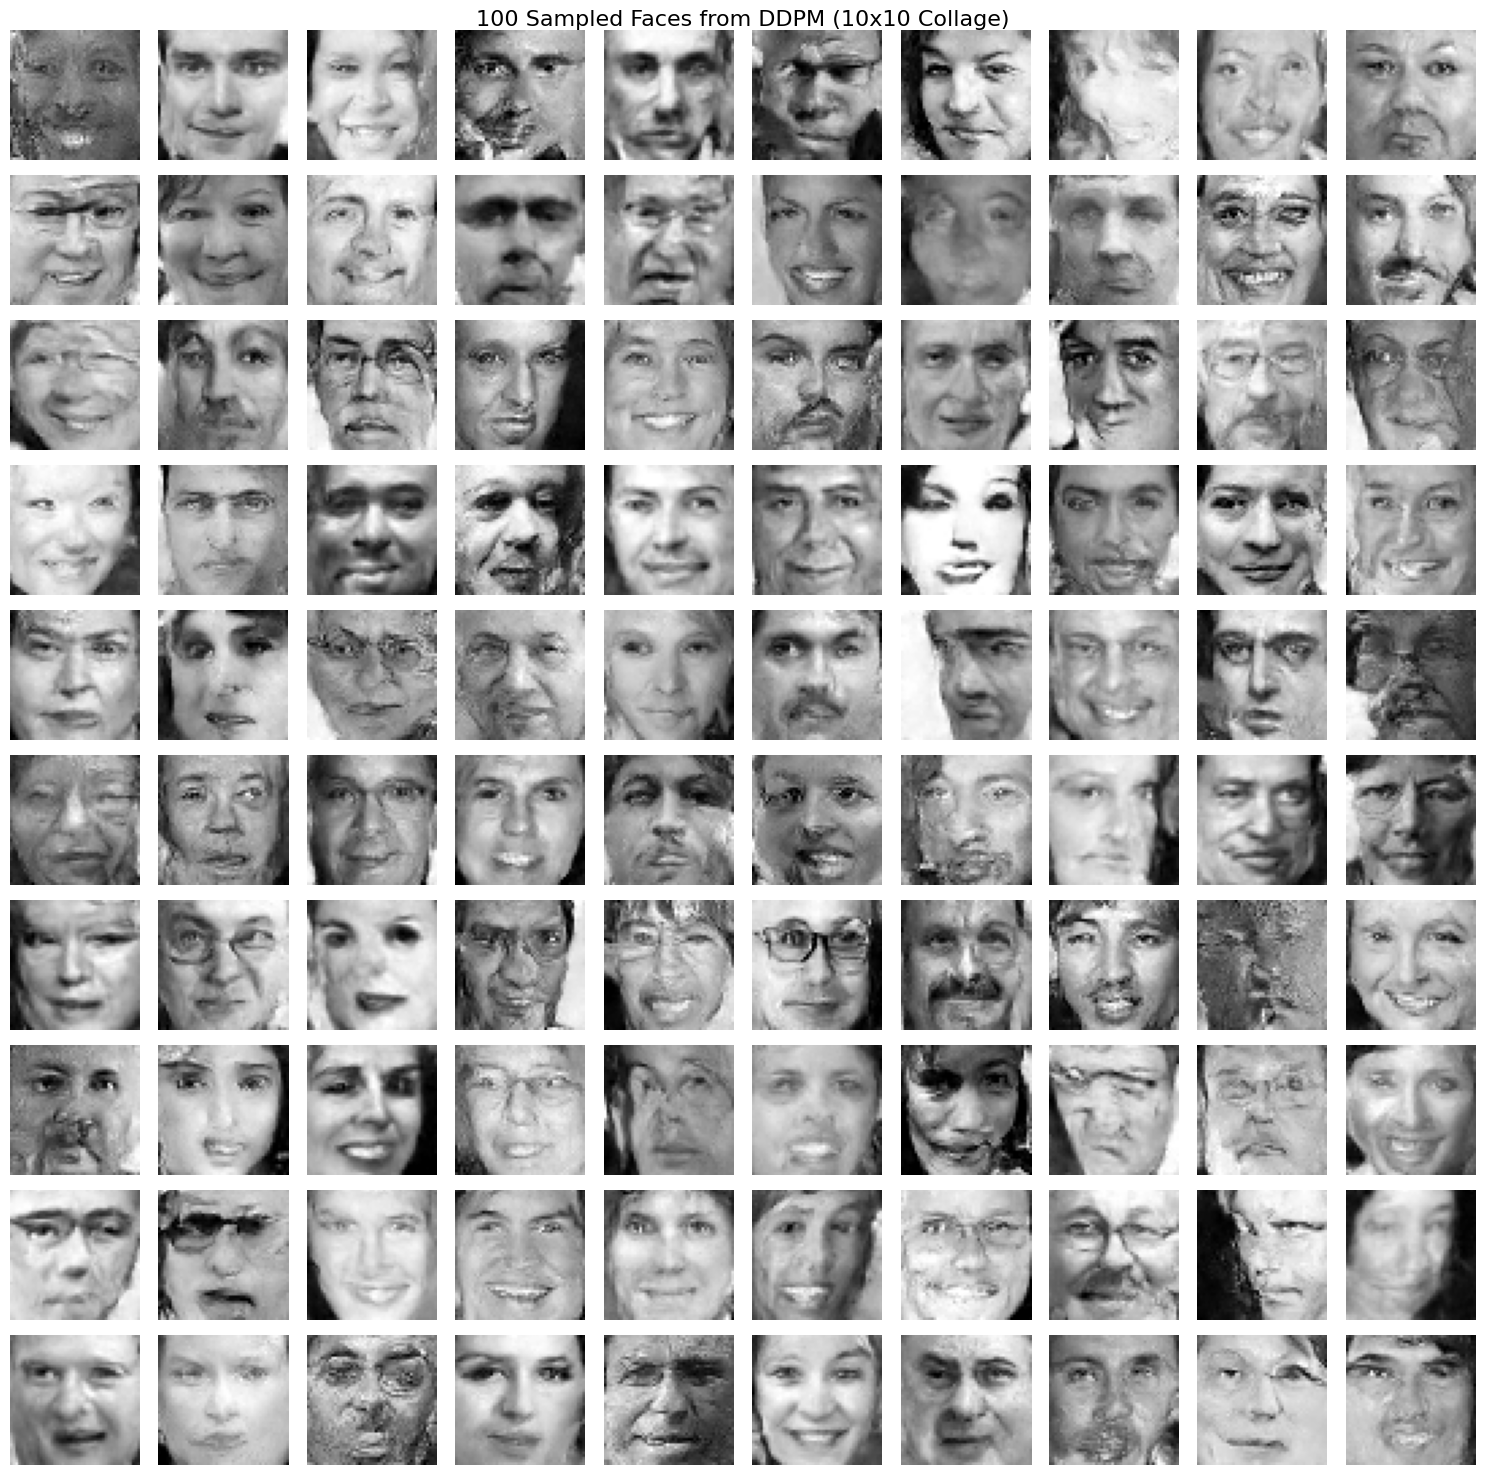

Sampling complete!


In [5]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torchvision import datasets, transforms
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np


class CustomDataset(Dataset):
    def __init__(self, image_file, age_file):
        raw = np.load(image_file)  # Load data from .npy file
        self.ages = np.load(age_file)
        self.data = raw / 255.
        self.transform = transforms.Compose([
            transforms.ToTensor(),  # Convert numpy array to PyTorch tensor
            transforms.RandomHorizontalFlip(),
            transforms.v2.RandomPhotometricDistort(),
            transforms.Normalize((0.5,), (0.5,))  # Normalize data
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = self.transform(image)
        return image, self.ages[idx]

device = 'cuda'  # 'cuda'
T = 1000
TIME_EMBEDDING_DIM = 64

def sinusoidal_embedding(times):
    embedding_min_frequency = 1.0
    frequencies = torch.exp(
        torch.linspace(
            np.log(1.0),
            np.log(1000.),
            TIME_EMBEDDING_DIM // 2
        )
    ).view(1, -1).to(times.device)
    angular_speeds = 2.0 * torch.pi * frequencies
    times = times.view(-1, 1).float()
    embeddings = torch.cat(
        [torch.sin(times.matmul(angular_speeds) / T), torch.cos(times.matmul(angular_speeds) / T)], dim=1
    )
    return embeddings

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.dconv_down1 = double_conv(in_channels + TIME_EMBEDDING_DIM, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = double_conv(832, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, time_index):
        time_embedding = sinusoidal_embedding(time_index)
        x = torch.cat([x, time_embedding.unsqueeze(-1).unsqueeze(-1).expand(x.size(0), -1, x.size(2), x.size(3))], dim=1)

        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)
        x = torch.cat([x, time_embedding.unsqueeze(-1).unsqueeze(-1).expand(x.size(0), -1, x.size(2), x.size(3))], dim=1)

        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

model = UNet(1, 1).to(device)
model.load_state_dict(torch.load("diff_unet_faces.cpt"))
model.eval()
betas = torch.linspace(1e-4, 0.01, T, dtype=torch.float32).to(device)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

def ddpm_sample(model, num_samples=100, img_size=48):
    model.eval()
    with torch.no_grad():
        x = torch.randn(num_samples, 1, img_size, img_size).to(device)
        for t in reversed(range(T)):
            t_tensor = torch.tensor([t] * num_samples).to(device)
            predicted_noise = model(x, t_tensor)
            alpha_t = alphas[t]
            alpha_bar_t = alphas_bar[t]
            beta_t = betas[t]
            mean = (1.0 / torch.sqrt(alpha_t)) * (
                x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * predicted_noise
            )
            
            if t > 0:
                z = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = mean + sigma_t * z
            else:
                x = mean
        return x


print("Sampling ...")
sampled_faces = ddpm_sample(model, num_samples=100, img_size=48)

sampled_faces = sampled_faces.cpu().numpy()
sampled_faces = (sampled_faces + 1.0) / 2.0 
sampled_faces = np.clip(sampled_faces, 0, 1)

fig, axes = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('100 Sampled Faces from DDPM (10x10 Collage)', fontsize=16)

for i in range(10):
    for j in range(10):
        idx = i * 10 + j
        axes[i, j].imshow(sampled_faces[idx, 0], cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

print("Sampling complete!")

In [6]:
faces_tensor = torch.tensor(sampled_faces * 2 - 1.0, dtype=torch.float32).to(device)


faces_tensor = faces_tensor[:10]

def q_sample(x0, t):
    sqrt_alpha_bar = torch.sqrt(alphas_bar[t]).view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar = torch.sqrt(1 - alphas_bar[t]).view(-1, 1, 1, 1)
    noise = torch.randn_like(x0)
    return sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise


def p_sample_from_t(model, z_t, t_start):
    x = z_t.clone()
    with torch.no_grad():
        for t in reversed(range(t_start + 1)):
            t_tensor = torch.tensor([t] * x.size(0)).to(device)
            predicted_noise = model(x, t_tensor)
            alpha_t = alphas[t]
            alpha_bar_t = alphas_bar[t]
            beta_t = betas[t]

            mean = (1.0 / torch.sqrt(alpha_t)) * (
                x - (beta_t / torch.sqrt(1.0 - alpha_bar_t)) * predicted_noise
            )

            if t > 0:
                z = torch.randn_like(x)
                sigma_t = torch.sqrt(beta_t)
                x = mean + sigma_t * z
            else:
                x = mean
    return x


def merge_faces(model, x1, x2, t):
    num_samples = x1.size(0)
    t_tensor = torch.tensor([t] * num_samples).to(device)

    z1_t = q_sample(x1, t_tensor)
    z2_t = q_sample(x2, t_tensor)

    _, _, H, W = z1_t.shape
    zt = torch.cat([z1_t[:, :, :, :W//2], z2_t[:, :, :, W//2:]], dim=3)

    merged_x = p_sample_from_t(model, zt, t)
    return merged_x


pairs = [(faces_tensor[i].unsqueeze(0), faces_tensor[i+5].unsqueeze(0)) for i in range(5)]

t_values = [111, 333, 666, 999]

results = []

print("\nMerging faces...")
for t in t_values:
    row_images = []
    for (x1, x2) in pairs:
        merged = merge_faces(model, x1, x2, t)

        row_images.extend([
            (x1.cpu() + 1) / 2,  
            (x2.cpu() + 1) / 2,
            (merged.cpu() + 1) / 2
        ])
    results.append(row_images)



Merging faces...


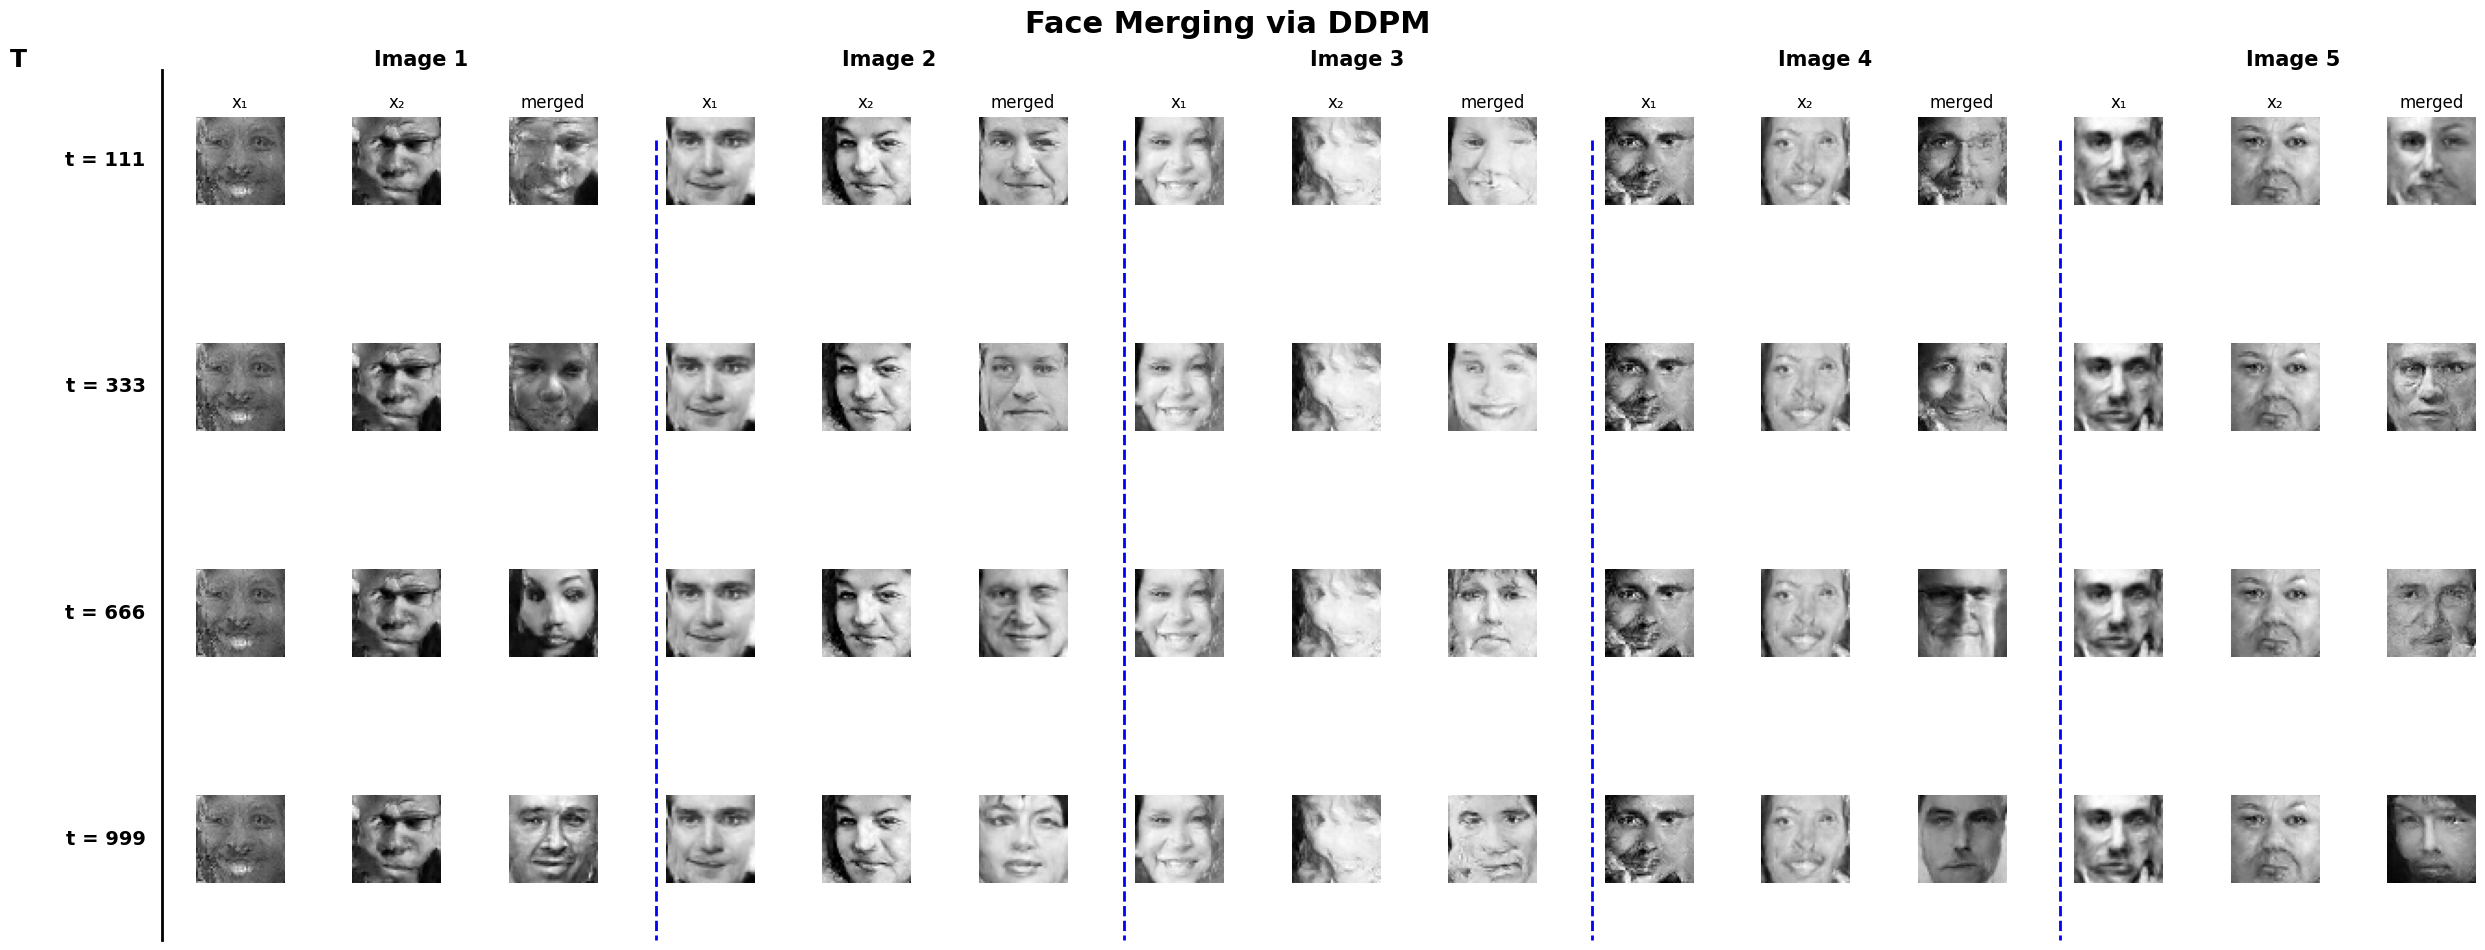

In [7]:

def visualize_face_merging(results, t_values):
    n_t = len(t_values)
    n_pairs = len(results[0]) // 3
    triplet_labels = ['x₁', 'x₂', 'merged']

    fig, axes = plt.subplots(
        n_t, n_pairs * 3 + 1,  
        figsize=(26, 10),
        gridspec_kw={'width_ratios': [0.5] + [1]*(n_pairs*3)},
    )

    fig.suptitle("Face Merging via DDPM", fontsize=22, weight='bold', y=0.98)

    fig.text(0.035, 0.93, 'T', ha='center', va='center', fontsize=18, weight='bold')

    for k in range(n_pairs):
        x_start = 0.10 + (k * 3) * (0.9 / (n_pairs * 3))
        x_end = 0.10 + ((k + 1) * 3) * (0.9 / (n_pairs * 3))
        x_center = (x_start + x_end) / 2
        fig.text(x_center, 0.93, f'Image {k+1}', ha='center', va='center',
                 fontsize=15, weight='bold')

    for i, row in enumerate(results):
        axes[i, 0].text(0.5, 0.5, f"t = {t_values[i]}",
                        ha='center', va='center', fontsize=14, weight='bold')
        axes[i, 0].axis('off')

        for j, img in enumerate(row):
            ax = axes[i, j + 1]
            ax.imshow(img[0, 0].numpy(), cmap='gray')
            ax.axis('off')

            if i == 0:
                label = triplet_labels[j % 3]
                ax.set_title(label, fontsize=12, pad=6)

    fig.lines.append(mlines.Line2D([0.09, 0.09], [0.05, 0.92],
                                   color='black', linewidth=2, transform=fig.transFigure))

    for k in range(1, n_pairs):

        x_start = 0.10 + (k * 3) * (0.9 / (n_pairs * 3))

        fig.lines.append(
            mlines.Line2D([x_start, x_start], [0.85, 0.05],  
                          color='blue', linestyle='--', linewidth=2,
                          transform=fig.transFigure)
        )

    plt.subplots_adjust(left=0.06, right=0.98, top=0.9, bottom=0.08, wspace=0.8, hspace=0.6)
    plt.show()



visualize_face_merging(results, t_values)